# LOGISTIC REGRESSION WITH TENSORFLOW

<a id="ref1"></a>
<h2>What is different between Linear and Logistic Regression?</h2>

While Linear Regression is suited for estimating continuous values (e.g. estimating house price), it is not the best tool for predicting the class in which an observed data point belongs. In order to provide estimate for classification, we need some sort of guidance on what would be the <b>most probable class</b> for that data point. For this, we use <b>Logistic Regression</b>.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size="3"><strong>Recall linear regression:</strong></font>
<br>
<br>
Linear regression finds a function that relates a continuous dependent variable, <i>y</i>, to some predictors (independent variables <i>x1</i>, <i>x2</i>, etc.). Simple linear regression assumes a function of the form:
<br><br>
$$
y = w0 + w1 \times x1 + w2 \times x2 + \cdots
$$
<br>
and finds the values of <i>w0</i>, <i>w1</i>, <i>w2</i>, etc. The term <i>w0</i> is the "intercept" or "constant term" (it's shown as <i>b</i> in the formula below):
<br><br>
$$
Y = W X + b
$$
<p></p>

</div>

Logistic Regression is a variation of Linear Regression, useful when the observed dependent variable, <i>y</i>, is categorical. It produces a formula that predicts the probability of the class label as a function of the independent variables.

Despite the name logistic <i>regression</i>, it is actually a <b>probabilistic classification</b> model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y} = exp(y) / (1 + exp(y)) = p 
$$

which produces p-values between 0 (as y approaches minus infinity $-\infty$) and 1 (as y approaches plus infinity $+\infty$). This now becomes a special kind of non-linear regression.

In this equation, <i>y</i> is the regression result (the sum of the variables weighted by the coefficients), <code>exp</code> is the exponential function and $\theta(y)$ is the <a href="http://en.wikipedia.org/wiki/Logistic_function">logistic function</a>, also called logistic curve. It is a common "S" shape (sigmoid curve), and was first developed for modeling population growth.

You might also have seen this function before, in another configuration:

$$
ProbabilityOfaClass = \theta(y) = \frac{1}{1+e^{-y}}
$$

So, briefly, Logistic Regression passes the input through the logistic/sigmoid function but then treats the result as a probability:

<img src="https://ibm.box.com/shared/static/kgv9alcghmjcv97op4d6onkyxevk23b1.png" width="400" align="center">


<h2>Utilizing Logistic Regression in TensorFlow</h2>

For us to utilize Logistic Regression in TensorFlow, we first need to import the required libraries.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will load the dataset we are going to use. In this case, we are utilizing the <code>iris</code> dataset, which is inbuilt -- so there's no need to do any preprocessing and we can jump right into manipulating it. We separate the dataset into <i>xs</i> and <i>ys</i>, and then into training <i>xs</i> and <i>ys</i> and testing <i>xs</i> and <i>ys</i>, (pseudo)randomly.

<h3>Understanding the Data</h3>

<h4><code>Iris Dataset</code>:</h4>

This dataset was introduced by British Statistician and Biologist Ronald Fisher, it consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). In total it has 150 records under five attributes - petal length, petal width, sepal length, sepal width and species. <a href="https://archive.ics.uci.edu/ml/datasets/iris">Dataset source</a>

Attributes
Independent Variable
<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variable
<ul>    
    <li>Species
        <ul>
            <li>Iris setosa</li>
            <li>Iris virginica</li>
            <li>Iris versicolor</li>
        </ul>
    </li>
</ul>
<br>

In [2]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values     # One-hot Coding
train_X, test_X, train_Y, test_Y = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

Now we define x and y. These placeholders will hold our iris data (both the features and label matrices), and help pass them along to different parts of the algorithm. You can consider placeholders as empty shells into which we insert our data. We also need to give them shapes which correspond to the shape of our data. Later, we will insert data into these placeholders by “feeding” the placeholders the data via a “feed_dict” (Feed Dictionary).

<h3>Why use Placeholders?</h3>

<ol>
    <li>This feature of TensorFlow allows us to create an algorithm which accepts data and knows something about the shape of the data without knowing the amount of data going in.</li>
    <li>When we insert “batches” of data in training, we can easily adjust how many examples we train on in a single step without changing the entire algorithm.</li>
</ol>

In [3]:
# num_features is the number of features in our input data.
# In the iris dataset, this number is '4'.
num_features = train_X.shape[1]

# num_labels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
num_labels = train_Y.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
with tf.name_scope('PlaceHolders'):
    # Iris has 4 features, so X is a tensor to hold our data.
    X = tf.placeholder(tf.float32, name='X', shape=[None, num_features]) 
    
    # This will be our correct answers matrix for 3 classes.
    y = tf.placeholder(tf.float32, name='y', shape=[None, num_labels]) 

<h3>Set model weights and bias</h3>

Much like Linear Regression, we need a shared variable weight matrix for Logistic Regression. We initialize both <code>w</code> and <code>b</code> as tensors full of zeros. Since we are going to learn <code>w</code> and <code>b</code>, their initial value does not matter too much. These variables are the objects which define the structure of our regression model, and we can save them after they have been trained so we can reuse them later.

We define two TensorFlow variables as our parameters. These variables will hold the weights and biases of our logistic regression and they will be continually updated during training. 

Notice that <code>w</code> has a shape of [4, 3] because we want to multiply the 4-dimensional input vectors by it to produce 3-dimensional vectors of evidence for the difference classes. <code>b</code> has a shape of [3] so we can add it to the output. Moreover, unlike our placeholders above which are essentially empty shells waiting to be fed data, TensorFlow variables need to be initialized with values, e.g. with zeros.

In [4]:
with tf.name_scope('Variables'):
    #Randomly sample from a normal distribution with standard deviation .01
    w = tf.Variable(tf.random_normal([num_features, num_labels],
                                     mean=0, stddev=0.01), name="Weights")
    
    b = tf.Variable(tf.random_normal([1, num_labels],
                                     mean=0, stddev=0.01), name="Biases")

<h3>Logistic Regression model</h3>

We now define our operations in order to properly run the Logistic Regression. Logistic regression is typically thought of as a single equation:

$$
ŷ =sigmoid(WX+b)
$$

However, for the sake of clarity, we can have it broken into its three main components: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 

As such, you will find these components defined as three separate operations below.


In [5]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
with tf.name_scope('Model'):
    Y = tf.nn.sigmoid(tf.add(tf.matmul(X, w), b))

As we have seen before, the function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 percent curve, which is the probability function we want.

<h2>Training</h2>

The learning algorithm is how we search for the best weight vector (${\bf w}$). This search is an optimization problem looking for the hypothesis that optimizes an error/cost measure.

<b>What tell us our model is bad?</b>  
The Cost or Loss of the model, so what we want is to minimize that. 

<b>What is the cost function in our model?</b>  
The cost function we are going to utilize is the Squared Mean Error loss function.

<b>How to minimize the cost function?</b>   
We can't use <b>least-squares linear regression</b> here, so we will use <a href="http://en.wikipedia.org/wiki/Gradient_descent">gradient descent</a> instead. Specifically, we will use batch gradient descent which calculates the gradient from all data points in the data set.

<h3>Cost function</h3>
Before defining our cost function, we need to define how long we are going to train and how should we define the learning rate.

In [6]:
# Defining our learning rate iterations (decay)
learning_rate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=train_X.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [7]:
with tf.name_scope('Cost'):
    # Defining our cost function - Squared Mean Error
    loss = tf.reduce_mean(-y * tf.log(Y) - (1 - y) * tf.log(1 - Y))

    # Defining our Gradient Descent
    train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

Now we move on to actually running our operations. We will start with the operations involved in the prediction phase (i.e. the logistic regression itself).

First, we need to initialize our weights and biases with zeros or random values via the inbuilt Initialization Op, <b>tf.initialize_all_variables()</b>. This Initialization Op will become a node in our computational graph, and when we put the graph into a session, then the Op will run and create the variables.

In [10]:
# Number of Epochs in our training
epochs = 500

with tf.Session() as sess:    
    # Initialize our weights and biases variables.
    init = tf.global_variables_initializer()
    sess.run(init)

    # Summary ops
    model_summary = tf.summary.histogram("output", Y)
    cost_summary = tf.summary.scalar("cost", loss)

    # Summary ops to check how variables (W, b) are updating after each iteration
    weight_summary = tf.summary.histogram("weights", w.eval(session=sess))
    bias_summary = tf.summary.histogram("biases", b.eval(session=sess))

    # Merge all summaries
    merged = tf.summary.merge([model_summary, cost_summary, weight_summary, bias_summary])
    writer = tf.summary.FileWriter("summary_logs")
    writer.add_graph(sess.graph)
    

    # Initialize reporting variable
    loss_val = []

    # Training epochs
    for i in range(epochs):
        _, loss_ = sess.run([train, loss], feed_dict={X:train_X, y:train_Y})
        if i % 10 == 0:
            _, loss_, merged_ = sess.run([train, loss, merged], feed_dict={X:train_X, y:train_Y})
            loss_val.append(loss_)
            writer.add_summary(merged_, i)
        
    Y_ = sess.run(Y, feed_dict={X:train_X, y:train_Y})
    writer.close()


<b>Plot Loss Values</b>

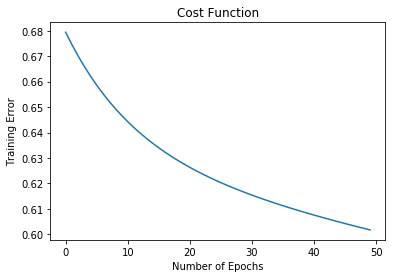

In [12]:
plt.plot(loss_val)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Error')
plt.title('Cost Function')
plt.show()

<b>Why don't we plot the cost to see how it behaves?</b>

In [11]:
! tensorboard --logdir='summary_logs/'

W0306 22:46:34.579967 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0306 22:46:34.579967 139965412587264 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
TensorBoard 1.12.0 at http://b658f36adccd:6006 (Press CTRL+C to quit)
^C
